Train shape: (614, 13)
Test shape: (367, 12)

Train columns:
 ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


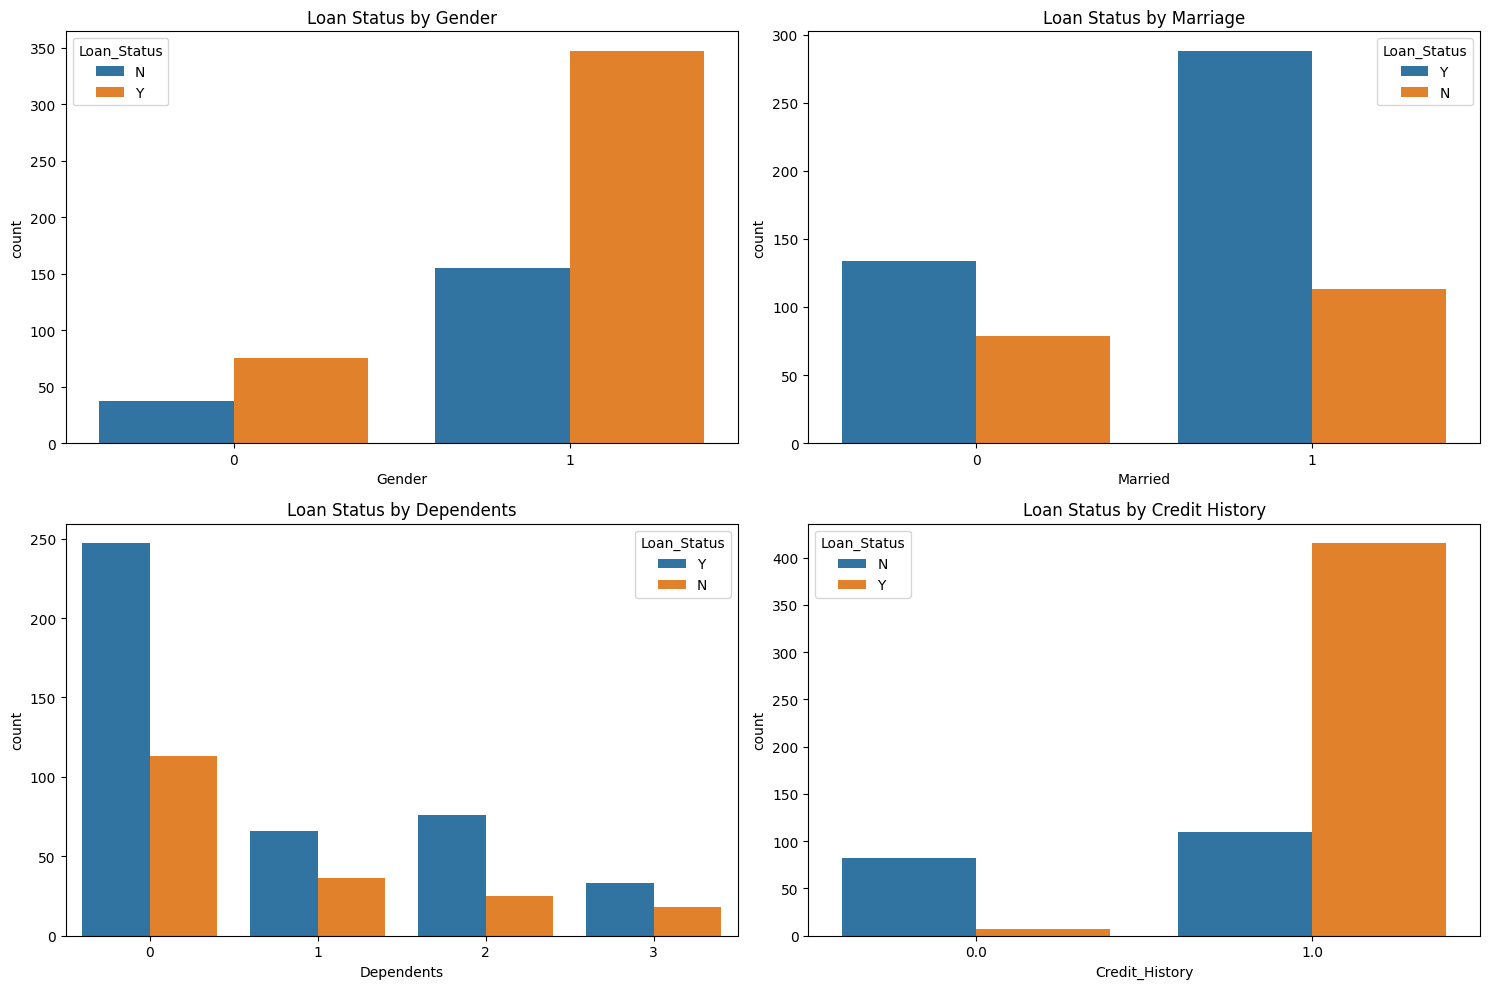

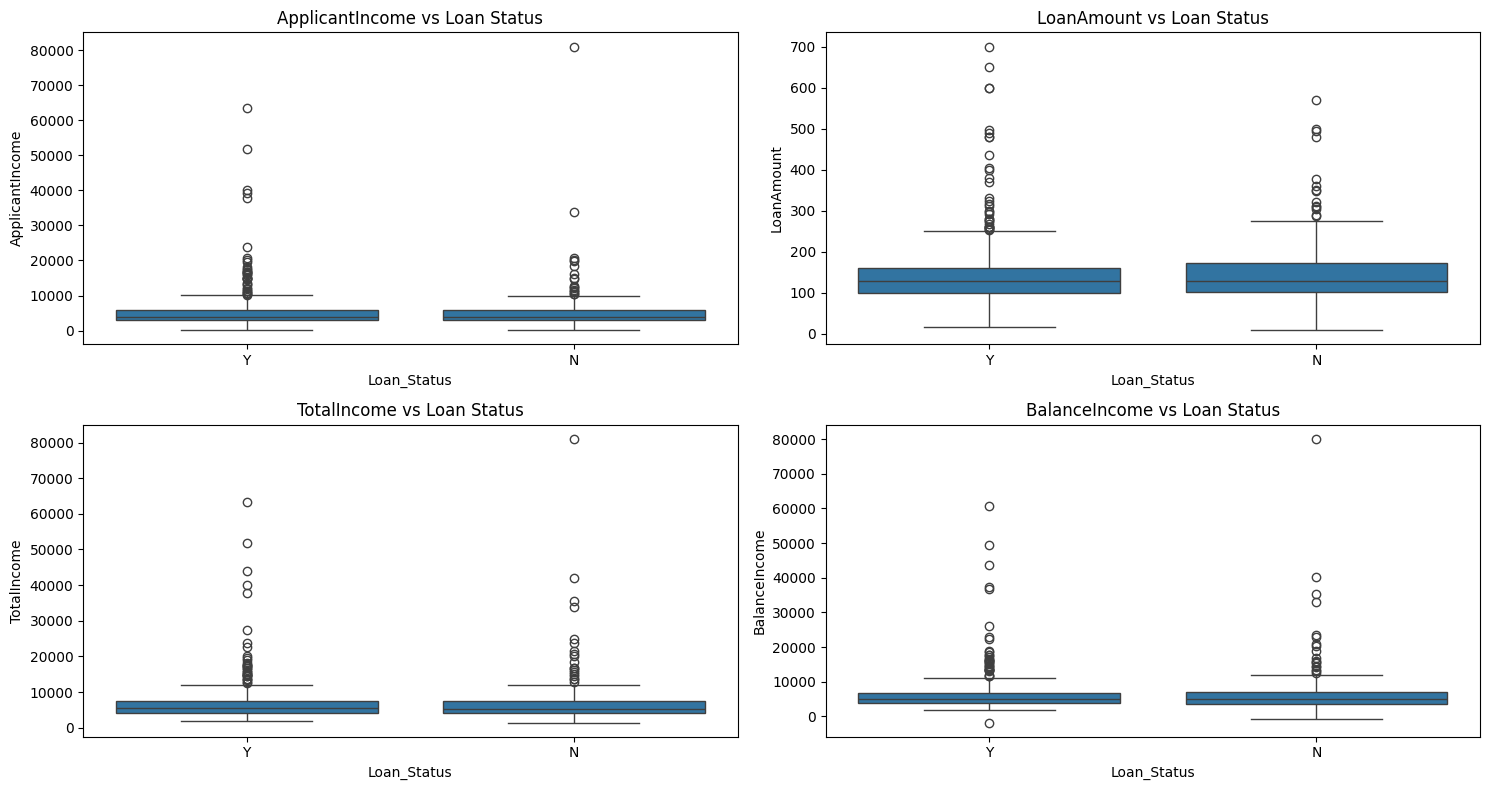

=== Training Performance ===
Accuracy: 0.9042769857433809

Confusion Matrix:
[[105  44]
 [  3 339]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.82       149
           1       0.89      0.99      0.94       342

    accuracy                           0.90       491
   macro avg       0.93      0.85      0.88       491
weighted avg       0.91      0.90      0.90       491


=== Validation Performance ===
Accuracy: 0.7723577235772358

Confusion Matrix:
[[19 24]
 [ 4 76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.44      0.58        43
           1       0.76      0.95      0.84        80

    accuracy                           0.77       123
   macro avg       0.79      0.70      0.71       123
weighted avg       0.78      0.77      0.75       123



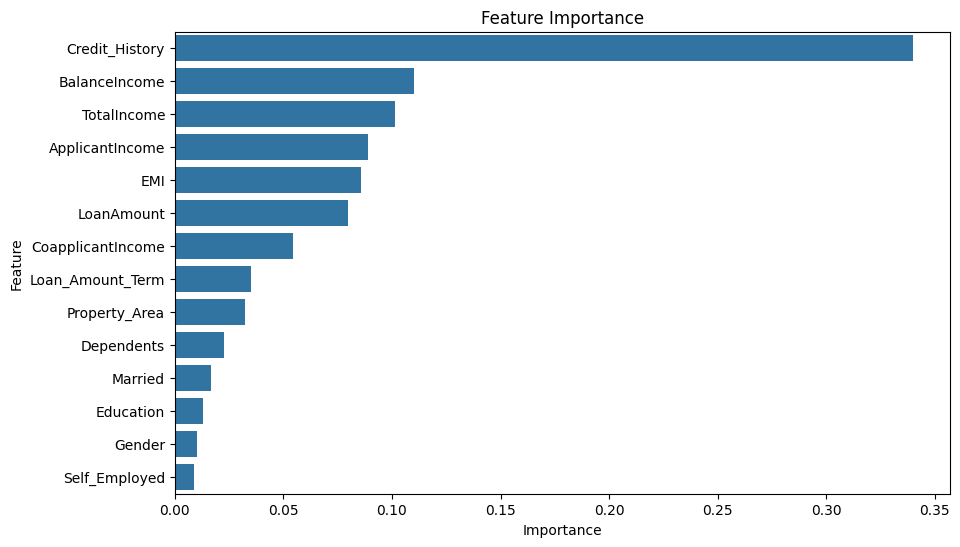

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Submission file created successfully!


In [ ]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# 2. DATA LOADING
# Load datasets (upload these files first)
train = pd.read_csv("/content/drive/MyDrive/loan-train.csv")
test = pd.read_csv("/content/drive/MyDrive/loan-test.csv")

# Quick peek
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain columns:\n", train.columns.tolist())

# 3. DATA PREPROCESSING
def preprocess_data(df, is_train=True):
    # Handle missing values
    df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
    df['Married'].fillna(df['Married'].mode()[0], inplace=True)
    df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
    df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
    df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)
    df['Credit_History'].fillna(df['Credit_History'].median(), inplace=True)

    # Feature engineering
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
    df['BalanceIncome'] = df['TotalIncome'] - (df['EMI'] * 1000)  # EMI in actual rupees

    # Label encoding
    cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
                'Self_Employed', 'Property_Area']
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Drop unnecessary columns
    to_drop = ['Loan_ID']
    if not is_train:
        to_drop.append('Loan_Status') if 'Loan_Status' in df.columns else None

    return df.drop(to_drop, axis=1)

# Preprocess both datasets
X_train = preprocess_data(train)
y_train = X_train.pop('Loan_Status').map({'Y':1, 'N':0})
X_test = preprocess_data(test, is_train=False)

# 4. EXPLORATORY ANALYSIS
plt.figure(figsize=(15,10))

# Categorical features
plt.subplot(2,2,1)
sns.countplot(x='Gender', hue='Loan_Status', data=train)
plt.title('Loan Status by Gender')

plt.subplot(2,2,2)
sns.countplot(x='Married', hue='Loan_Status', data=train)
plt.title('Loan Status by Marriage')

plt.subplot(2,2,3)
sns.countplot(x='Dependents', hue='Loan_Status', data=train)
plt.title('Loan Status by Dependents')

plt.subplot(2,2,4)
sns.countplot(x='Credit_History', hue='Loan_Status', data=train)
plt.title('Loan Status by Credit History')

plt.tight_layout()
plt.show()

# Numerical features
num_cols = ['ApplicantIncome', 'LoanAmount', 'TotalIncome', 'BalanceIncome']
plt.figure(figsize=(15,8))
for i,col in enumerate(num_cols,1):
    plt.subplot(2,2,i)
    sns.boxplot(x='Loan_Status', y=col, data=train)
    plt.title(f'{col} vs Loan Status')
plt.tight_layout()
plt.show()

# 5. MODEL TRAINING
# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
model.fit(X_train, y_train)

# 6. MODEL EVALUATION
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

print("=== Training Performance ===")
evaluate_model(model, X_train, y_train)

print("\n=== Validation Performance ===")
evaluate_model(model, X_val, y_val)

# Feature Importance
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=features)
plt.title('Feature Importance')
plt.show()

# 7. PREDICTIONS & SUBMISSION
# Predict on test data
test_pred = model.predict(X_test)
test_proba = model.predict_proba(X_test)[:,1]  # Probability of approval

# Create submission file
submission = pd.DataFrame({
    'Loan_ID': test['Loan_ID'],
    'Loan_Status': np.where(test_pred == 1, 'Y', 'N'),
    'Probability': test_proba
})

# Save and download
submission.to_csv('loan_prediction_submission.csv', index=False)
files.download('loan_prediction_submission.csv')

print("\nSubmission file created successfully!")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# 1. LOAD AND PREPARE TRAINING DATA

def load_and_preprocess_data():
    # Load dataset (replace with your actual data path)
    train = pd.read_csv("/content/drive/MyDrive/loan-train.csv")

    # Handle missing values
    train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
    train['Married'].fillna(train['Married'].mode()[0], inplace=True)
    train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
    train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
    train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
    train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(), inplace=True)
    train['Credit_History'].fillna(train['Credit_History'].median(), inplace=True)

    # Feature engineering
    train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
    train['EMI'] = train['LoanAmount'] / train['Loan_Amount_Term']
    train['BalanceIncome'] = train['TotalIncome'] - (train['EMI'] * 1000)

    # Label encoding
    cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
                'Self_Employed', 'Property_Area']
    le = LabelEncoder()
    for col in cat_cols:
        train[col] = le.fit_transform(train[col])

    # Prepare features and target
    X = train.drop(['Loan_ID', 'Loan_Status'], axis=1)
    y = train['Loan_Status'].map({'Y':1, 'N':0})

    return X, y

# 2. TRAIN THE MODEL
print("Training the model...")
X, y = load_and_preprocess_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
model.fit(X_train, y_train)

# Verify model is trained
val_accuracy = model.score(X_val, y_val)
print(f"Model trained successfully! Validation accuracy: {val_accuracy:.2%}")

# 3. USER INPUT PROCESSING
def get_application_input():
    print("\n" + "="*50)
    print("LOAN ELIGIBILITY PREDICTION SYSTEM")
    print("="*50 + "\n")

    return {
        'Gender': input("• Gender (Male/Female): ").strip().capitalize(),
        'Married': input("• Married? (Yes/No): ").strip().capitalize(),
        'Dependents': input("• Number of Dependents (0/1/2/3+): ").strip(),
        'Education': input("• Education (Graduate/Not Graduate): ").strip().capitalize(),
        'Self_Employed': input("• Self Employed? (Yes/No): ").strip().capitalize(),
        'ApplicantIncome': float(input("• Applicant Monthly Income (₹): ")),
        'CoapplicantIncome': float(input("• Co-applicant Monthly Income (₹): ")),
        'LoanAmount': float(input("• Loan Amount (₹ in thousands): ")),
        'Loan_Amount_Term': float(input("• Loan Term (months): ")),
        'Credit_History': float(input("• Credit History (1=Good, 0=Bad): ")),
        'Property_Area': input("• Property Area (Urban/Semiurban/Rural): ").strip().capitalize()
    }

def preprocess_input(input_dict):
    input_df = pd.DataFrame([input_dict])

    # Feature engineering
    input_df['TotalIncome'] = input_df['ApplicantIncome'] + input_df['CoapplicantIncome']
    input_df['EMI'] = input_df['LoanAmount'] / input_df['Loan_Amount_Term']
    input_df['BalanceIncome'] = input_df['TotalIncome'] - (input_df['EMI'] * 1000)

    # Label encoding (must match training)
    encoding_maps = {
        'Gender': {'Male': 1, 'Female': 0},
        'Married': {'Yes': 1, 'No': 0},
        'Dependents': {'0': 0, '1': 1, '2': 2, '3+': 3},
        'Education': {'Graduate': 1, 'Not Graduate': 0},
        'Self_Employed': {'Yes': 1, 'No': 0},
        'Property_Area': {'Urban': 2, 'Semiurban': 1, 'Rural': 0}
    }

    for col, mapping in encoding_maps.items():
        input_df[col] = input_df[col].map(mapping)

    # Ensure column order matches training
    return input_df[X.columns]

# 4. PREDICTION AND RESULTS
def predict_and_display(processed_data):
    prediction = model.predict(processed_data)[0]
    proba = model.predict_proba(processed_data)[0][1]

    print("\n" + "="*50)
    print("PREDICTION RESULTS")
    print("="*50)
    print(f"\n► Loan Status: {'APPROVED' if prediction == 1 else 'REJECTED'}")
    print(f"► Confidence: {proba*100:.1f}%")

    print("\nKey Factors:")
    print(f"• Credit History: {'Good' if processed_data['Credit_History'].values[0] == 1 else 'Bad'}")
    print(f"• Debt-to-Income Ratio: {(processed_data['EMI'].values[0]/processed_data['TotalIncome'].values[0])*100:.1f}%")
    print(f"• Total Income: ₹{processed_data['TotalIncome'].values[0]:,.2f}/month")

# 5. MAIN EXECUTION
if __name__ == "__main__":
    try:
        while True:
            application_data = get_application_input()
            processed_data = preprocess_input(application_data)
            predict_and_display(processed_data)

            if input("\nPredict another application? (y/n): ").lower() != 'y':
                break

    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        print("Please check your inputs and try again.")

Training the model...
Model trained successfully! Validation accuracy: 77.24%

LOAN ELIGIBILITY PREDICTION SYSTEM

• Gender (Male/Female): Female
• Married? (Yes/No): Yes
• Number of Dependents (0/1/2/3+): 2
• Education (Graduate/Not Graduate): Graduate
• Self Employed? (Yes/No): Yes
• Applicant Monthly Income (₹): 75000
• Co-applicant Monthly Income (₹): 55000
• Loan Amount (₹ in thousands): 2000000
• Loan Term (months): 36
• Credit History (1=Good, 0=Bad): 1
• Property Area (Urban/Semiurban/Rural): Urban

PREDICTION RESULTS

► Loan Status: REJECTED
► Confidence: 43.7%

Key Factors:
• Credit History: Good
• Debt-to-Income Ratio: 42.7%
• Total Income: ₹130,000.00/month

Predict another application? (y/n): n


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Function to load and preprocess training data
def load_and_preprocess_data():
    train = pd.read_csv("/content/drive/MyDrive/loan-train.csv")

    # Handle missing values
    train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
    train['Married'].fillna(train['Married'].mode()[0], inplace=True)
    train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
    train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
    train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
    train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(), inplace=True)
    train['Credit_History'].fillna(train['Credit_History'].median(), inplace=True)

    # Feature engineering
    train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
    train['EMI'] = train['LoanAmount'] / train['Loan_Amount_Term']
    train['BalanceIncome'] = train['TotalIncome'] - (train['EMI'] * 1000)

    # Label encoding
    cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
                'Self_Employed', 'Property_Area']
    le = LabelEncoder()
    for col in cat_cols:
        train[col] = le.fit_transform(train[col])

    # Prepare features and target
    X = train.drop(['Loan_ID', 'Loan_Status'], axis=1)
    y = train['Loan_Status'].map({'Y':1, 'N':0})

    return X, y

# Load and split data
print("Training the model...")
X, y = load_and_preprocess_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
model.fit(X_train, y_train)

# Save model and feature columns
with open("loan_model.pkl", "wb") as f:
    pickle.dump(model, f)
with open("feature_columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

# Validation accuracy
val_accuracy = model.score(X_val, y_val)
print(f"Model trained successfully! Validation accuracy: {val_accuracy:.2%}")


Training the model...


<ipython-input-3-5b02bc41b73a>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
<ipython-input-3-5b02bc41b73a>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

Model trained successfully! Validation accuracy: 77.24%


In [ ]:
import pandas as pd
import pickle

# Load trained model and feature columns
with open("loan_model.pkl", "rb") as f:
    model = pickle.load(f)
with open("feature_columns.pkl", "rb") as f:
    feature_columns = pickle.load(f)

# Function to take user input
def get_application_input():
    print("\n" + "="*50)
    print("LOAN ELIGIBILITY PREDICTION SYSTEM")
    print("="*50 + "\n")

    return {
        'Gender': input("• Gender (Male/Female): ").strip().capitalize(),
        'Married': input("• Married? (Yes/No): ").strip().capitalize(),
        'Dependents': input("• Number of Dependents (0/1/2/3+): ").strip(),
        'Education': input("• Education (Graduate/Not Graduate): ").strip().capitalize(),
        'Self_Employed': input("• Self Employed? (Yes/No): ").strip().capitalize(),
        'ApplicantIncome': float(input("• Applicant Monthly Income (₹): ")),
        'CoapplicantIncome': float(input("• Co-applicant Monthly Income (₹): ")),
        'LoanAmount': float(input("• Loan Amount (₹ in thousands): ")),
        'Loan_Amount_Term': float(input("• Loan Term (months): ")),
        'Credit_History': float(input("• Credit History (1=Good, 0=Bad): ")),
        'Property_Area': input("• Property Area (Urban/Semiurban/Rural): ").strip().capitalize()
    }

# Function to preprocess input
def preprocess_input(input_dict):
    input_df = pd.DataFrame([input_dict])

    # Feature engineering
    input_df['TotalIncome'] = input_df['ApplicantIncome'] + input_df['CoapplicantIncome']
    input_df['EMI'] = input_df['LoanAmount'] / input_df['Loan_Amount_Term']
    input_df['BalanceIncome'] = input_df['TotalIncome'] - (input_df['EMI'] * 1000)

    # Label encoding
    encoding_maps = {
        'Gender': {'Male': 1, 'Female': 0},
        'Married': {'Yes': 1, 'No': 0},
        'Dependents': {'0': 0, '1': 1, '2': 2, '3+': 3},
        'Education': {'Graduate': 1, 'Not Graduate': 0},
        'Self_Employed': {'Yes': 1, 'No': 0},
        'Property_Area': {'Urban': 2, 'Semiurban': 1, 'Rural': 0}
    }

    for col, mapping in encoding_maps.items():
        input_df[col] = input_df[col].map(mapping)

    # Ensure column order matches training
    return input_df[feature_columns]

# Function to predict and display results
def predict_and_display(processed_data):
    prediction = model.predict(processed_data)[0]
    proba = model.predict_proba(processed_data)[0][1]

    print("\n" + "="*50)
    print("PREDICTION RESULTS")
    print("="*50)
    print(f"\n► Loan Status: {'APPROVED' if prediction == 1 else 'REJECTED'}")
    print(f"► Confidence: {proba*100:.1f}%")

    print("\nKey Factors:")
    print(f"• Credit History: {'Good' if processed_data['Credit_History'].values[0] == 1 else 'Bad'}")
    print(f"• Debt-to-Income Ratio: {(processed_data['EMI'].values[0]/processed_data['TotalIncome'].values[0])*100:.1f}%")
    print(f"• Total Income: ₹{processed_data['TotalIncome'].values[0]:,.2f}/month")

# Main execution
if __name__ == "__main__":
    try:
        while True:
            application_data = get_application_input()
            processed_data = preprocess_input(application_data)
            predict_and_display(processed_data)

            if input("\nPredict another application? (y/n): ").lower() != 'y':
                break

    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        print("Please check your inputs and try again.")



LOAN ELIGIBILITY PREDICTION SYSTEM

• Gender (Male/Female): Male
• Married? (Yes/No): No
• Number of Dependents (0/1/2/3+): 2
• Education (Graduate/Not Graduate): Graduate
• Self Employed? (Yes/No): Yes
• Applicant Monthly Income (₹): 50000
• Co-applicant Monthly Income (₹): 35000
• Loan Amount (₹ in thousands): 350000
• Loan Term (months): 120
• Credit History (1=Good, 0=Bad): 1
• Property Area (Urban/Semiurban/Rural): Urban

PREDICTION RESULTS

► Loan Status: REJECTED
► Confidence: 38.5%

Key Factors:
• Credit History: Good
• Debt-to-Income Ratio: 3.4%
• Total Income: ₹85,000.00/month

Predict another application? (y/n): n


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

def load_and_preprocess_data():
    # Load dataset
    train = pd.read_csv("/content/drive/MyDrive/loan-train.csv")

    # Handle missing values
    train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
    train['Married'].fillna(train['Married'].mode()[0], inplace=True)
    train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
    train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
    train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
    train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(), inplace=True)
    train['Credit_History'].fillna(train['Credit_History'].median(), inplace=True)

    # Feature engineering
    train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
    train['EMI'] = train['LoanAmount'] / train['Loan_Amount_Term']
    train['BalanceIncome'] = train['TotalIncome'] - (train['EMI'] * 1000)  # EMI in actual rupees

    # Label encoding
    cat_cols = ['Gender', 'Married', 'Dependents', 'Education',
                'Self_Employed', 'Property_Area']
    le = LabelEncoder()
    for col in cat_cols:
        train[col] = le.fit_transform(train[col])

    # Prepare features and target
    X = train.drop(['Loan_ID', 'Loan_Status'], axis=1)
    y = train['Loan_Status'].map({'Y':1, 'N':0})

    return X, y

# Train and save model
X, y = load_and_preprocess_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate model
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
print(f"Training Accuracy: {train_score:.2%}")
print(f"Validation Accuracy: {val_score:.2%}")

# Save the model
import os
os.makedirs('model', exist_ok=True)  # Create model directory if it doesn't exist
joblib.dump(model, 'model/loan_model.pkl')

# Save the column order for future reference
columns = X.columns.tolist()
joblib.dump(columns, 'model/feature_columns.pkl')

print("Model trained and saved successfully!")

<ipython-input-3-1ba78d5cc88e>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
<ipython-input-3-1ba78d5cc88e>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

Training Accuracy: 90.43%
Validation Accuracy: 77.24%
Model trained and saved successfully!
